## Imports

In [1]:
import librosa
import numpy as np
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

## Data preparation

In [2]:
target_sr = 16000

def parse_time(time_str):
    dt = datetime.strptime(time_str, "%Y-%m-%d_%H-%M-%S-%f")
    # Convert to total seconds since the start of the day
    total_seconds = dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1e6
    return dt, total_seconds  # Return both datetime object and total seconds

def segment_audio(file_path, label_file):
    y, sr = librosa.load(file_path, sr=None)
    y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    with open(label_file, 'r') as f:
        lines = f.readlines()
    
    labels = []
    for line in lines[1:]:
        if(" | " not in line):
            continue
        time_str, position = line.strip().split(' | ')
        dt, total_seconds = parse_time(time_str)
        labels.append([dt, total_seconds, float(position)])
    labels = np.array(labels)
    
    times = labels[:, 1]  # Total seconds since midnight
    dates = labels[:, 0]  # Datetime objects
    positions = labels[:, 2]  # Positions
    
    segments_with_speed = []
    cursor = 0  # Start at the beginning of the audio file
    
    deltaTime = 1
    imax = len(times) - 1
    while(imax % deltaTime != 0 ):
        imax = imax - 1
    for i in range(0, imax, deltaTime):
        start_time = times[i]
        end_time = times[i + deltaTime]
        start_date = dates[i]
        end_date = dates[i + deltaTime]
        
        # Check for day change
        if end_date.date() > start_date.date():
            segment_length = (86400 - start_time) + end_time  # 86400 seconds in a day
        else:
            segment_length = end_time - start_time
        
        end_sample = cursor + int(segment_length * target_sr)
        
        if cursor >= end_sample or segment_length < 0.1:
            print(f"Warning: Empty or realy small segment detected. Cursor: {cursor}, End: {end_sample}")
            continue
        
        segment = y[cursor:end_sample]
        speed = (positions[i+deltaTime] - positions[i]) / segment_length
        
        #Text file longer than audio file trigger this or sometime last segment is too small
        if(len(segment) == 0 or segment.shape[0] < deltaTime*1740):
            continue

        segments_with_speed.append((segment, speed))
        
        cursor = end_sample  # Move cursor to the start of the next segment
    
    return segments_with_speed

def extract_audio_features(segments):
    features = []
    for segment in segments:
        # Convert to mono if necessary
        if segment.ndim > 1:
            segment = librosa.to_mono(segment)
        

        mfccs = librosa.feature.mfcc(y=segment, sr=target_sr, n_mfcc=13, n_fft=1024)
        #print(mfccs.shape)
        mfcc_mean = np.mean(mfccs, axis=1)
        #print(mfcc_mean.shape)

        spectral_centroid = librosa.feature.spectral_centroid(y=segment, sr=target_sr, n_fft=1024)    
        #print(spectral_centroid)
        spectral_centroid_mean = np.mean(spectral_centroid, axis=1)
        #print(spectral_centroid_mean.shape)

        rms = librosa.feature.rms(y=segment)
        rms_mean = np.mean(rms, axis=1)
        #print(rms_mean.shape)

        #mel_spec = librosa.feature.melspectrogram(y=segment, sr=target_sr, n_fft=1024)
        #mel_spec_mean = np.mean(mel_spec, axis=1)
        #print(mel_spec_mean.shape)

        # Combine features for this segment
        segment_features = np.hstack((mfcc_mean, spectral_centroid_mean,rms_mean)) #, mel_spec_mean
        features.append(segment_features)

    #Normalize features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    return np.array(normalized_features)

def classify_speed(speeds):
    """    
    :param speeds: List or array of speeds in inch-minutes
    :return: List of class labels from 1 to 100
    """
    # Convert speeds to numpy array for vectorized operations
    speeds = np.array(speeds)
    
    # Normalize speeds
    max_speed = 2.5622110090806607 #max(speeds) if max(speeds) > 0 else 1  # Find the real one
    normalized_speeds = np.clip(speeds / max_speed, 0, 1)
    
    # Classify into 100 classes
    # Multiply by 100 to get a range from 0 to 100, then convert to integer
    # Since we want classes from 1 to 100, we add 1 to the result
    classes = np.clip(np.round(normalized_speeds * 100), 0, 99)
    
    return classes.astype(int)  # Ensure the result is an integer array

In [3]:
directory = "../DataSP/Test/"
segments_and_speed = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if the file is a .wav file
    if filename.endswith(".wav"):
        # Construct the full file path
        filepath = os.path.join(directory, filename)
        segments_and_speed.extend(segment_audio(filepath, filepath[:-3] + "txt"))

In [4]:

segments, speeds = zip(*segments_and_speed)
#truncate the segments so that they all have the same shape
min_len = min(len(segment) for segment in segments)
print(min_len)
truncated_segments = [segment[:min_len] for segment in segments]

npSegments = np.vstack(truncated_segments)
# Calculate the absolute maximum value across all segments
max_val = np.max(np.abs(npSegments))

# Normalize by dividing by the maximum value
normalized_segments = npSegments / max_val

#Extract features
normalized_audio_features = extract_audio_features(normalized_segments)
normalized_audio_features = np.squeeze(normalized_audio_features)

#Apply PCA to keep only the best features
#pca = PCA(n_components=0.90)
#pca_features = pca.fit_transform(normalized_audio_features)

# You can check how many components were actually used
#n_components = pca.n_components_
#print(f"Number of components to explain 90% variance: {n_components} out of {normalized_audio_features.shape[1]}")

# Convert speeds to numpy array for consistency with features
speeds = np.array(speeds)

#normalize speed
normalized_speeds = classify_speed(speeds)

# Ensure features and labels are aligned
#assert len(audio_features) == len(normalized_speeds), "Mismatch in feature and label counts"

X_train, X_test, y_train, y_test = train_test_split(normalized_audio_features, normalized_speeds, test_size=0.2, random_state=42)

1743


## Model, training and testing

In [5]:
class KernelLogisticClassification(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel="rbf",C=0.1, max_iter=1000, n_components=1800, gamma=1, learning_rate=0.01):
        self.kernel = kernel
        self.C = C
        self.max_iter = max_iter
        self.n_components = n_components
        self.gamma = gamma
        self.alpha = None
        self.rbf_feature = None
        self.learning_rate = learning_rate
        self.classes_ = np.array(range(100))
    def softmax(self, x):
        # Compute softmax values for each sets of scores in x
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)  

    def fit(self, X, y):
        if(self.rbf_feature == None):
            self.rbf_feature = RBFSampler(n_components=self.n_components, gamma=self.gamma, random_state=42)
            
        X_transformed = self.rbf_feature.fit_transform(X)
        # One-hot encode y if it's not already
        if y.ndim == 1:
            y = np.eye(len(self.classes_))[y]
        
        # Calculate alpha using least squares
        # Here, we're using the normal equation for simplicity, 
        # but in practice, you might want to use something like SVD for stability
        X_transpose = X_transformed.T
        self.alpha = np.linalg.inv(X_transpose @ X_transformed + np.eye(X_transformed.shape[1]) * self.C) @ X_transpose @ y

        return self

    def predict_proba(self, X):
        X_transformed = self.rbf_feature.transform(X)

        return self.softmax(X_transformed.dot(self.alpha))

    def predict(self, X):
        if(self.rbf_feature == None):
            self.rbf_feature = RBFSampler(n_components=self.n_components, gamma=self.gamma, random_state=42)

        argmax_indices = np.argmax(self.predict_proba(X), axis=1)
        return self.classes_[argmax_indices]
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [6]:
#Define the parameter grid including gamma
#param_grid = {
    #'C': [0.1, 1],
    #'n_components': [1750],
    #'gamma': [0.1, 1],   # 'scale' and 'auto' are special values for gamma
#}

#param_grid = {
    #'C': [0.1],  # Regularization parameter
    #'n_components': [1800],#,1000,1250  # Number of components for RBFSampler
    #'gamma': [1]  # Kernel coefficient for 'rbf'
#}

model = KernelLogisticRegression()
print(X_train.shape)
print(y_train.shape)
model.fit(X_train, y_train)
#grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2,
                                            #n_jobs=-1,
                                            #error_score='raise',  # Changed for potential error handling
                           #verbose=10
#)
#
#grid_search.fit(X_train, y_train)
#
#best_model = grid_search.best_estimator_

(319128, 15)
(319128,)


KernelLogisticRegression()

## Validation

In [7]:
def evaluate_model(y_true, y_pred, num_classes=100):
    """
    Comprehensive model evaluation function for multi-class classification
    
    Parameters:
    - y_true: Ground truth labels
    - y_pred: Predicted labels
    - num_classes: Total number of classes (default 100)
    
    Returns:
    - Classification report
    - Plots accuracy per class
    - Generates confusion matrix visualization
    """
    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    # Per-class accuracy
    per_class_accuracy = []
    for cls in range(num_classes):
        cls_mask = (y_true == cls)
        if np.sum(cls_mask) > 0:
            cls_accuracy = np.mean(y_pred[cls_mask] == cls)
            per_class_accuracy.append((cls, cls_accuracy))
    
    # Sort accuracies for better visualization
    per_class_accuracy.sort(key=lambda x: x[1])
    
    # Plotting per-class accuracy
    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    classes, accuracies = zip(*per_class_accuracy)
    plt.bar(classes, accuracies)
    plt.title('Accuracy per Class')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=90)
    
    # Histogram of accuracies
    plt.subplot(122)
    plt.hist(accuracies, bins=20)
    plt.title('Distribution of Class Accuracies')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Confusion Matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot both raw and normalized confusion matrices
    plt.subplot(121)
    sns.heatmap(cm, annot=False, cmap='Blues')
    plt.title('Confusion Matrix (Raw Counts)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    plt.subplot(122)
    sns.heatmap(cm_normalized, annot=False, cmap='viridis')
    plt.title('Confusion Matrix (Normalized)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    plt.tight_layout()
    plt.show()
    
    return per_class_accuracy


Accuracy: 0.5515
Precision (macro): 0.5434
Recall (macro): 0.4869
F1-score (macro): 0.4859
Classification Report:


c:\Users\verre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\verre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\verre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       464
           1       0.49      0.88      0.63      1704
           2       0.87      0.73      0.79       574
           3       0.75      0.77      0.76       701
           4       0.58      0.88      0.70      1111
           5       0.78      0.77      0.77       575
           6       0.74      0.83      0.78       726
           7       0.58      0.87      0.69      1219
           8       0.70      0.88      0.78       811
           9       0.65      0.73      0.68       992
          10       0.53      0.85      0.65      1790
          11       0.83      0.54      0.65       494
          12       0.57      0.74      0.64      1261
          13       0.68      0.38      0.49      1129
          14       0.73      0.18      0.29       910
          15       0.71      0.54      0.61      1121
          16       0.75      0.48      0.59       761
          17       0.54    

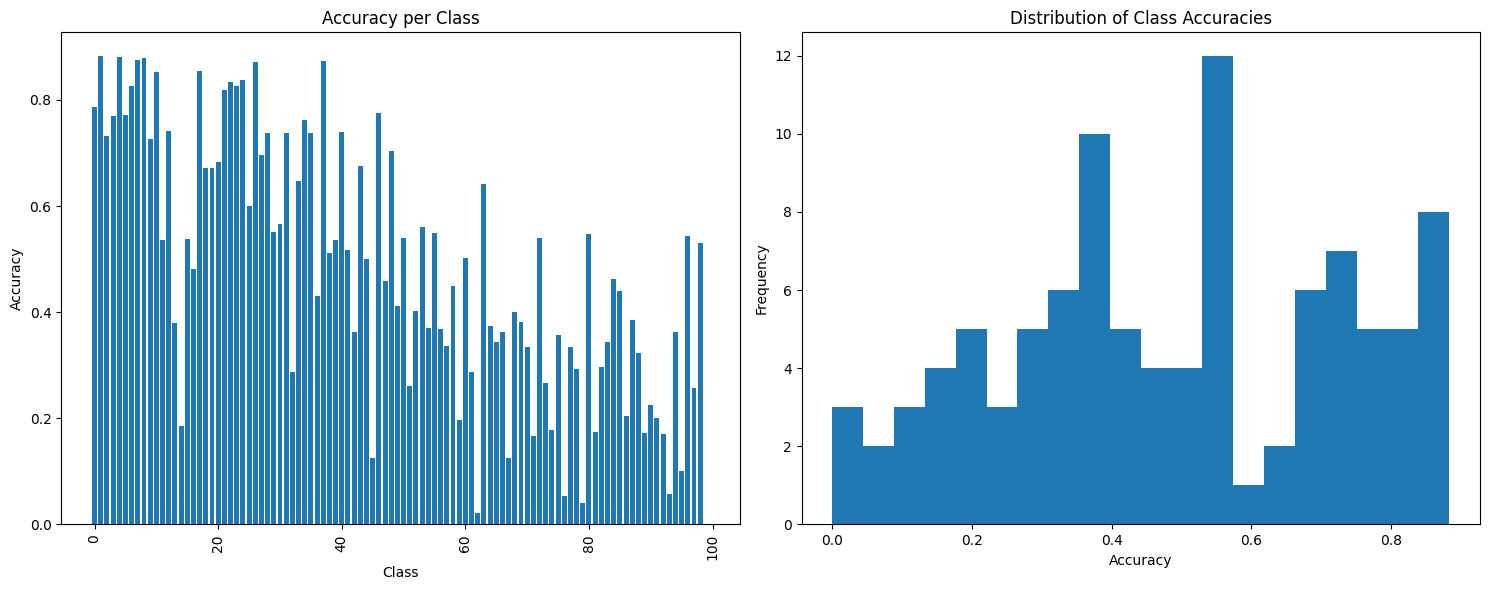

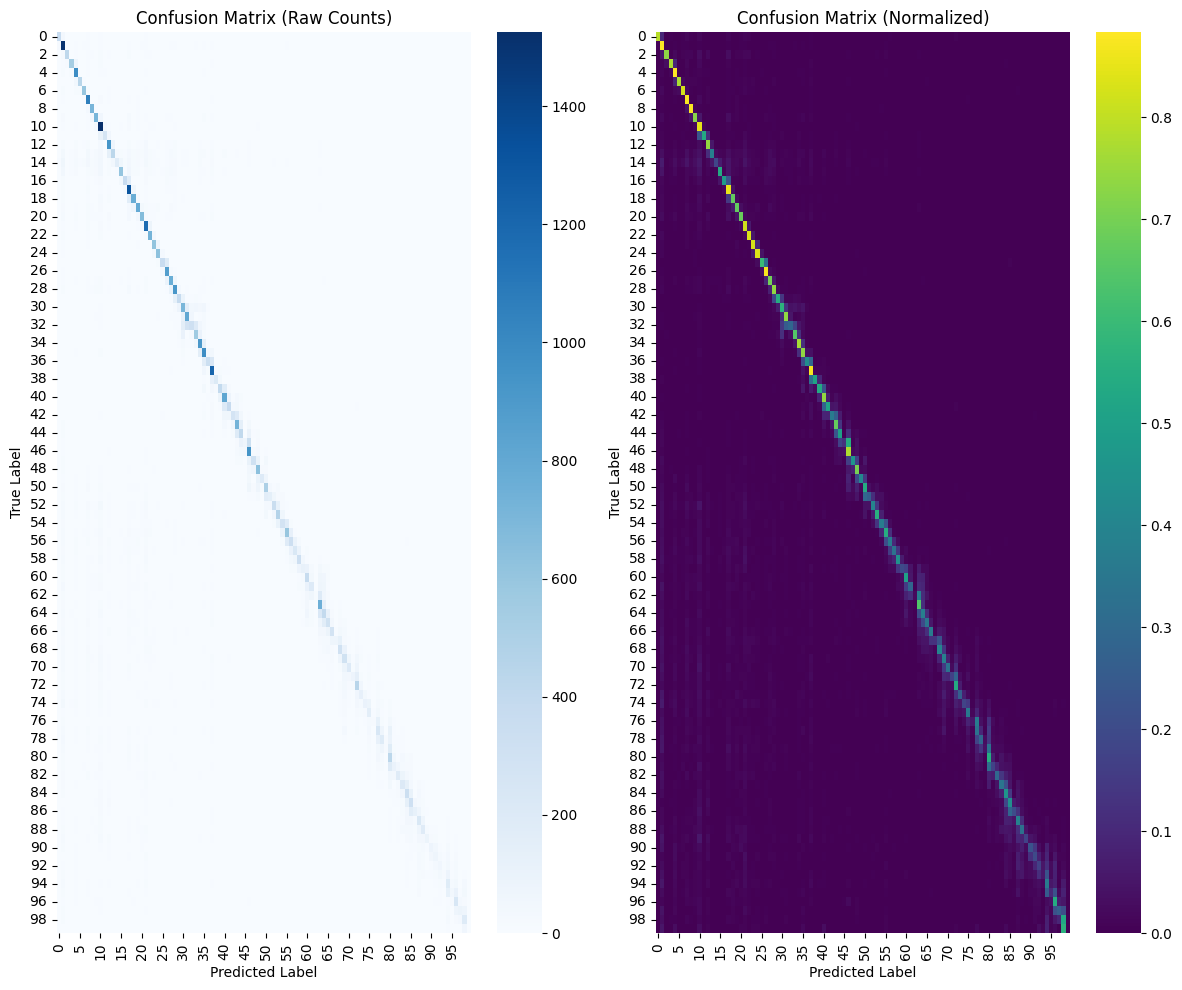

In [8]:
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Precision, Recall, and F1-score (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Precision (macro): {precision:.4f}')
print(f'Recall (macro): {recall:.4f}')
print(f'F1-score (macro): {f1:.4f}')

per_class_accuracies = evaluate_model(y_test, y_pred)